# Modeling Vacancies in a Binary Compound With the Rock Salt Structure

In [206]:
using FreeBird
using Plots
using DataFrames
using CSV
using Distributions

In [207]:
function plot_lattice(lattice::LatticeSystem)
    x = lattice.positions[:, 1]
    y = lattice.positions[:, 2]
    z = lattice.positions[:, 3]
    
    # Create arrays for colors based on adsorption status
    colors = [if lattice.adsorptions[i] "red" else "blue" end for i in 1:length(x)]
    
    # Create the scatter plot for lattice points with hover labels
    hover_labels = [string("Atom ", i) for i in 1:length(x)]
    p = scatter3d(x, y, z, markersize=5, label="Lattice Points", legend=:topright, hover=hover_labels, color=colors)
    
    # Plot the lattice vectors
    origin = [0.0, 0.0, 0.0]
    a1 = lattice.lattice_vectors[:, 1]
    a2 = lattice.lattice_vectors[:, 2]
    a3 = lattice.lattice_vectors[:, 3]
    
    plot!(p, [origin[1], a1[1]], [origin[2], a1[2]], [origin[3], a1[3]], lw=2, label="a1", color=:red)
    plot!(p, [origin[1], a2[1]], [origin[2], a2[2]], [origin[3], a2[3]], lw=2, label="a2", color=:green)
    plot!(p, [origin[1], a3[1]], [origin[2], a3[2]], [origin[3], a3[3]], lw=2, label="a3", color=:blue)
    
    # Optionally, plot the bonds to neighbors
    for (i, (first_neighbors, second_neighbors)) in enumerate(lattice.neighbors)
        for j in first_neighbors
            plot!(p, [x[i], x[j]], [y[i], y[j]], [z[i], z[j]], lw=1, label="", color=:gray)
        end
        # for j in second_neighbors
        #     plot!(p, [x[i], x[j]], [y[i], y[j]], [z[i], z[j]], lw=1, linestyle=:dash, label="", color=:gray)
        # end
    end
    
    display(p)
end

plot_lattice (generic function with 1 method)

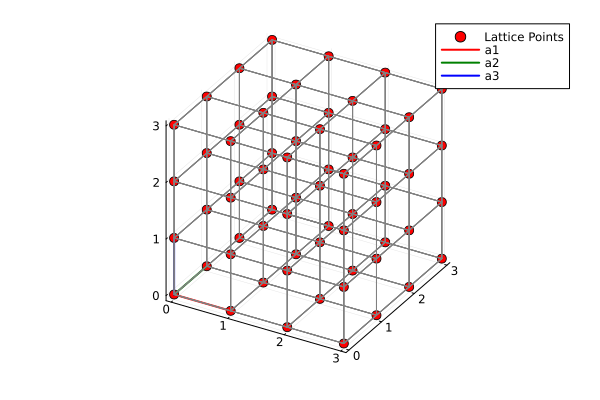

In [208]:
a = 1.0  # lattice constant
lattice_vectors = [a 0 0; 0 a 0; 0 0 a]
basis = [(0.0, 0.0, 0.0)]  # B sites
supercell_dimensions = (4, 4, 4)
periodicity = (true, true, true)
num_total_sites = prod(supercell_dimensions)*length(basis)
occupations = [true for i in 1:num_total_sites]
adsorptions = [true for i in 1:num_total_sites]
cutoff_radii = (1.1, 1.5)
lattice = LatticeSystem(
    lattice_vectors,
    basis,
    supercell_dimensions,
    periodicity,
    occupations,
    adsorptions,
    cutoff_radii
)
plot_lattice(lattice)

In [209]:
# Define modeling parameters
K = supercell_dimensions[1]
L = supercell_dimensions[2]
M = supercell_dimensions[3]
Ns = [1, 2, 3]
vacancy_formation_energy = 4.0
nn_interaction_energy = 1.0  # nearest-neighbor vacancy-vacancy interaction energy
nnn_interaction_energy = 0.1  # next-nearest-neighbor vacancy-vacancy interaction energy

0.1

## Exact Enumeration of Vacancies in a Binary Compound With the Rock Salt Structure

In [210]:
# Ensure the data directory exists
if !isdir("data")
    mkdir("data")
end

# Define parameters for exact enumeration
parameters = "exact_vacancy_in_rock_salt_K$(K)_L$(L)_M$(M)_adsorption$(vacancy_formation_energy)_nn$(nn_interaction_energy)_nnn$(nnn_interaction_energy)_cutoff$(cutoff_radii[1])_$(cutoff_radii[2])"
microstates_file = "data/microstates_$parameters.csv"

# Perform exact enumeration if data file does not exist
if !isfile(microstates_file)
    df_microstates = DataFrame(N = Int[], K = Int[], L = Int[], M = Int[], energy = Float64[], configurations = Any[])

    for N in Ns
        # Perform exact enumeration
        energies, configurations = exact_enumeration(
            lattice_vectors,
            basis,
            supercell_dimensions,
            periodicity,
            N,
            adsorptions,
            vacancy_formation_energy,
            nn_interaction_energy,
            nnn_interaction_energy,
            cutoff_radii
        )

        # Append energy configurations data to DataFrame
        for i in 1:length(energies)
            append!(df_microstates, DataFrame(N = N, K = K, L = L, M = M, energy = energies[i], configurations = configurations[i]))
        end
    end

    # Write DataFrames to CSV files
    CSV.write(microstates_file, df_microstates)
else
    println("Data file already exists")
end

Data file already exists


In [211]:
# Read microstates data from CSV file
df_microstates = CSV.read(microstates_file, DataFrame)

cv_file = "data/Cv_$parameters.csv"
# Calculate heat capacity if data file does not exist
if !isfile(cv_file)
    df_Cv = DataFrame(N = Int[], K = Int[], L = Int[], M = Int[], β = Float64[], T = Float64[], Cv = Float64[], U = Float64[])

    for N in unique(df_microstates.N)
        # Filter microstates data by N
        df_microstates_N = filter(row -> row.N == N, df_microstates)
        energies = df_microstates_N.energy
        configurations = df_microstates_N.configurations

        # Define temperature range and corresponding beta values
        Ts = collect(1.0:0.1:2000.0)  # temperatures in K
        βs = 1.0 ./ (k_B * Ts)  # 1/eV

        # Prepare energy values for Cv calculation
        ωis = ones(length(energies))
        Eis = [ustrip(energy) for energy in energies]
        dof = 0

        # Calculate Cv for each temperature
        Cv_values = [cv(β, ωis, Eis, dof) / k_B for β in βs]  # Cv in units of kB

        # Calculate U for each temperature
        U_values = [internal_energy(β, ωis, Eis) for β in βs]

        # Append Cv data to DataFrame
        append!(df_Cv, DataFrame(N = N, K = K, L = L, M = M, β = βs, T = Ts, Cv = Cv_values, U = U_values))
    end

    # Write DataFrames to CSV files
    CSV.write(cv_file, df_Cv)
else
    println("Data file already exists")
end

Data file already exists


In [212]:
# Ensure the figures directory exists
if !isdir("figures")
    mkdir("figures")
end

# Read heat capacity data from CSV file
df_Cv = CSV.read(cv_file, DataFrame)

# Plot internal energy as a function of temperature
p1 = plot()
for N in unique(df_Cv.N)
    df_Cv_N = filter(row -> row.N == N, df_Cv)
    plot!(p1, df_Cv_N.T, df_Cv_N.U ./ N, label="N = $N", xlabel="Temperature (K)", ylabel="Internal Energy (\$ k_{\\mathrm{B}} / N \$)")
end

# Plot heat capacity as a function of temperature
p2 = plot()
for N in unique(df_Cv.N)
    df_Cv_N = filter(row -> row.N == N, df_Cv)
    plot!(p2, df_Cv_N.T, df_Cv_N.Cv ./ N, label="N = $N", ylim=(0, 0.2), xlabel="Temperature (K)", ylabel="Heat Capacity (\$ k_{\\mathrm{B}} / N \$)")
end
plot(p1, p2, layout=(2, 1), size=(800, 800))

# Save the plot to a file
plot_file = "figures/plot_$parameters.png"
savefig(plot_file)

"/Users/wexler/PycharmProjects/FreeBird.jl/scripts/figures/plot_exact_vacancy_in_rock_salt_K4_L4_M4_adsorption4.0_nn1.0_nnn0.1_cutoff1.1_1.5.png"

# Markov Chain Monte Carlo (MCMC) Simulation of Vacancies in a Binary Compound With the Rock Salt Structure

In [230]:
# Ensure the data directory exists
if !isdir("data")
    mkdir("data")
end

# Define parameters for MCMC simulation
temperatures = 2000:-50:50
num_equilibration_steps = 10_000
num_sampling_steps = 10_000
random_seed = 1234

# Define file paths for data
parameters = "mc_vacancy_in_rock_salt_K$(K)_L$(L)_M$(M)_adsorption$(vacancy_formation_energy)_nn$(nn_interaction_energy)_nnn$(nnn_interaction_energy)_cutoff$(cutoff_radii[1])_$(cutoff_radii[2])"
cv_file = "data/Cv_$parameters.csv"

# Perform the Monte Carlo simulation if data files do not exist
if !isfile(cv_file)

    # Initialize a DataFrame to store the results
    df_samples = DataFrame(N = Int[], T = Float64[], E = Float64[], Cv = Float64[], acceptance_rate = Float64[])
    
    # Perform the Monte Carlo simulation
    for N in Ns
        println("N = $N -------------------")

        # Initialize the lattice
        occupations = [false for i in 1:num_total_sites]
        for i in sample(1:length(occupations), N, replace=false)
            occupations[i] = true
        end
        initial_lattice = LatticeSystem(
            lattice_vectors,
            basis,
            supercell_dimensions,
            periodicity,
            occupations,
            adsorptions,
            cutoff_radii
        )

        for temp in temperatures
            println("T = $temp")

            # Equilibrate the lattice
            temperature = Float64(temp)
            equilibration_energies, equilibration_configurations, equilibration_accepted_steps = nvt_monte_carlo(
                initial_lattice,
                vacancy_formation_energy,
                nn_interaction_energy,
                nnn_interaction_energy,
                temperature,
                num_equilibration_steps,
                random_seed
            )

            # Sample the lattice
            sampling_energies, sampling_configurations, sampling_accepted_steps = nvt_monte_carlo(
                equilibration_configurations[end],
                vacancy_formation_energy,
                nn_interaction_energy,
                nnn_interaction_energy,
                temperature,
                num_sampling_steps,
                random_seed
            )

            # Compute the heat capacity
            E = mean(sampling_energies)
            Cv = var(sampling_energies) / (k_B * temperature^2)

            # Compute the acceptance rate
            acceptance_rate = sampling_accepted_steps / num_sampling_steps

            # Append the results to the DataFrame
            append!(df_samples, DataFrame(N = N, T = temperature, E = E, Cv = Cv, acceptance_rate = acceptance_rate))

            # Update the initial lattice
            initial_lattice = deepcopy(sampling_configurations[end])
        end
    end

    # Write DataFrame to a CSV file
    CSV.write(cv_file, df_samples)
else
    println("Data files already exist.")
end

Data files already exist.


In [236]:
# Ensure the figures directory exists
if !isdir("figures")
    mkdir("figures")
end

# Read heat capacity data from CSV file
df_Cv_exact = CSV.read("data/Cv_exact_vacancy_in_rock_salt_K4_L4_M4_adsorption4.0_nn1.0_nnn0.1_cutoff1.1_1.5.csv", DataFrame)
df_Cv_mcmc = CSV.read("data/Cv_mc_vacancy_in_rock_salt_K4_L4_M4_adsorption4.0_nn1.0_nnn0.1_cutoff1.1_1.5.csv", DataFrame)

# Plot internal energy as a function of temperature
p1 = plot()
for N in Ns
    df_Cv_N_exact = filter(row -> row.N == N, df_Cv_exact)
    df_Cv_N_mcmc = filter(row -> row.N == N, df_Cv_mcmc)
    plot!(p1, df_Cv_N_exact.T, df_Cv_N_exact.U ./ N, label="Exact N = $N", xlabel="Temperature (K)", ylabel="Internal Energy (\$ k_{\\mathrm{B}} / N \$)", color=N)
    plot!(p1, df_Cv_N_mcmc.T, df_Cv_N_mcmc.E ./ N, label="MCMC N = $N", xlabel="Temperature (K)", ylabel="Internal Energy (\$ k_{\\mathrm{B}} / N \$)", color=N, linestyle=:dash)
end

# Plot heat capacity as a function of temperature
p2 = plot()
for N in Ns
    df_Cv_N_exact = filter(row -> row.N == N, df_Cv_exact)
    df_Cv_N_mcmc = filter(row -> row.N == N, df_Cv_mcmc)
    plot!(p2, df_Cv_N_exact.T, df_Cv_N_exact.Cv ./ N, label="Exact N = $N", xlabel="Temperature (K)", ylabel="Heat Capacity (\$ k_{\\mathrm{B}} / N \$)", color=N)
    plot!(p2, df_Cv_N_mcmc.T, df_Cv_N_mcmc.Cv ./ N / k_B, label="MCMC N = $N", xlabel="Temperature (K)", ylabel="Heat Capacity (\$ k_{\\mathrm{B}} / N \$)", color=N, linestyle=:dash)
end
plot!(p2, ylim=(0, 0.2))

plot(p1, p2, layout=(2, 1), size=(800, 800))

# Save the plot to a file
plot_file = "figures/plot_$parameters.png"
savefig(plot_file)

"/Users/wexler/PycharmProjects/FreeBird.jl/scripts/figures/plot_mc_vacancy_in_rock_salt_K4_L4_M4_adsorption4.0_nn1.0_nnn0.1_cutoff1.1_1.5.png"